In [1]:
!git clone https://github.com/imostafizur/CSE498R.git

Cloning into 'CSE498R'...
remote: Enumerating objects: 37061, done.
remote: Counting objects: 100% (536/536), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 37061 (delta 279), reused 490 (delta 250), pack-reused 36525
Receiving objects: 100% (37061/37061), 1.83 GiB | 33.97 MiB/s, done.
Resolving deltas: 100% (379/379), done.
Updating files: 100% (39003/39003), done.


## Malaraia Detection using InceptionV3

In [4]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import BaseLogger
from tensorflow.keras.callbacks import RemoteMonitor
from tensorflow.keras.callbacks import CallbackList
from tensorflow.keras.callbacks import Callback

In [5]:
image = 'CSE498R/cell_images'

In [6]:
# InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0001),
                metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


<keras.src.engine.input_layer.InputLayer object at 0x7ddd4c2eff70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ddd4c316b60> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ddd4c317940> False
<keras.src.layers.core.activation.Activation object at 0x7ddd4c317be0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ddd4ba40310> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ddd4ba417b0> False
<keras.src.layers.core.activation.Activation object at 0x7ddd4ba420e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ddd4ba424d0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ddd4ba439d0> False
<keras.src.layers.core.activation.Activation object at 0x7ddd4ba423b0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ddd4ba84490> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ddd4ba854

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [9]:
# Data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Data augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Data augmentation
train_generator = train_datagen.flow_from_directory(
        'CSE498R/cell_images',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 27558 images belonging to 2 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
        'CSE498R/cell_images',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 27558 images belonging to 2 classes.


In [16]:
val_generator = val_datagen.flow_from_directory(
        'CSE498R/cell_images',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 27558 images belonging to 2 classes.


In [17]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                mode='auto')

In [18]:
# Callbacks
earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=0,
                            mode='auto')

In [19]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=0,
                                mode='auto')

In [20]:
csv_logger = CSVLogger('log.csv',
                        append=False,
                        separator=',')

In [21]:
# Callbacks
tensorboard = TensorBoard(log_dir='logs',
                            histogram_freq=0,
                            write_graph=True,
                            write_images=True)

In [22]:

# Callbacks
lambda_callback = LambdaCallback(on_epoch_begin=None,
                                    on_epoch_end=None,
                                    on_batch_begin=None,
                                    on_batch_end=None,
                                    on_train_begin=None,
                                    on_train_end=None)

In [23]:
terminate_on_nan = TerminateOnNaN()

In [24]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=5216 // 32,
        epochs=100,
        validation_data=val_generator,
        validation_steps=624 // 32,
        callbacks=[checkpoint, earlystop, reduce_lr, tensorboard, csv_logger, lambda_callback, terminate_on_nan])

<ipython-input-24-90dac328fab3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
163/163 [==============================] - 75s 397ms/step - loss: 2.6352 - accuracy: 0.7619 - val_loss: 0.2646 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 39s 239ms/step - loss: 0.4573 - accuracy: 0.8164 - val_loss: 0.3038 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 37s 228ms/step - loss: 0.4201 - accuracy: 0.8330 - val_loss: 0.2779 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 69s 427ms/step - loss: 0.4082 - accuracy: 0.8328 - val_loss: 0.2598 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 38s 231ms/step - loss: 0.4314 - accuracy: 0.8131 - val_loss: 0.2823 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 38s 232ms/step - loss: 0.4135 - accuracy: 0.8252 - val_loss: 0.2769 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 7/100
163/163 [=========================

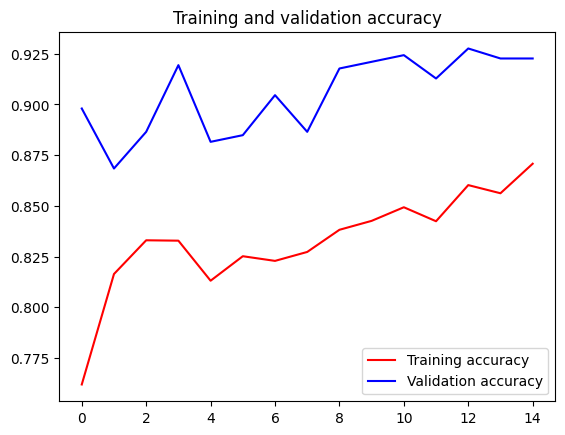

<Figure size 640x480 with 0 Axes>

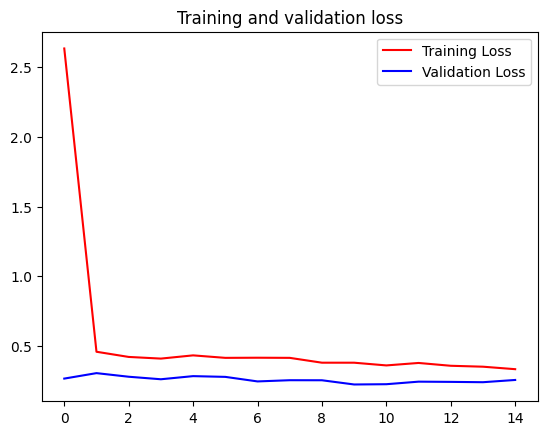

<Figure size 640x480 with 0 Axes>

In [25]:
#Plot the accuracy and loss curves for training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [27]:
# Save the model
model.save('Malaria_InceptionV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
